In [1]:
import pandas as pd
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import initialize_agent, load_tools
from langchain.tools import Tool,tool,StructuredTool
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    ToolMessage,
)
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId

#structuring
import ast

from dataclasses import dataclass
from typing_extensions import TypedDict
from typing import Annotated, Literal
from pydantic import BaseModel, Field
#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

import pytz
from datetime import datetime
import os
import requests
import json
from dotenv import load_dotenv 
from os import listdir
from os.path import isfile, join
import pipreqs

# flask-san
from flask import Flask, render_template, request

load_dotenv()

c:\Users\tristan\localllm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
GOOGLE_API_KEY=os.getenv('google_api_key')
pse=os.getenv('pse')
OPENWEATHERMAP_API_KEY=os.getenv('open_weather_key')
os.environ['OPENWEATHERMAP_API_KEY']=OPENWEATHERMAP_API_KEY

In [3]:
GEMINI_MODEL='gemini-1.5-flash'

In [4]:
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [6]:
# state
class State(TypedDict):
  """
  A dictionnary representing the state of the agent.
  """
  messages: Annotated[list, add_messages]
  trip_data: dict

In [7]:
@tool
def local_files_browser(tool_call_id: Annotated[str, InjectedToolCallId]) -> str:
  """
  tool to list the local schedule files.
  args:none
  """
  mypath=f'schedules/'
  onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
  if not onlyfiles:
    return Command(update={'messages':[ToolMessage(f'No files are available, try to upload one',tool_call_id=tool_call_id)]})
  else:
    return Command(update={'messages':[ToolMessage(f'Here are the available schedules: {onlyfiles}',tool_call_id=tool_call_id)]})

In [ ]:
@tool
def schedule_loader(tool_call_id: Annotated[str, InjectedToolCallId],state: Annotated[dict, InjectedState],filename: str) -> str:
  """
  Use this tool to load the schedule from local directory, which is a text file.
  args: filename - the name of the file, include the extention.
  """
  try:
    with open(f'schedules/{filename}', 'rb') as f:
      schedule=f.read()
      result=llm.invoke(f'format this schedule: {str(schedule)} into a json format in the output, do not include ```json```, do not include comments either')
      return Command(update={'trip_data':ast.literal_eval(result.content),
              'messages': [ToolMessage('Succesfully uploaded schedule',tool_call_id=tool_call_id)]})
  except:
      return Command(update={'meessages':[ToolMessage('No Schedule please try a different filename, or include the extention eg. filename.txt',tool_call_id=tool_call_id)]},
                     goto='local_files_browser')

In [9]:
@tool
def schedule_creator(tool_call_id: Annotated[str, InjectedToolCallId], schedule:str)->str:
  """Tool to create or add a schedule from the chat with the agent
  and then uses an llm to structure it.
  args: schedule - the schedule from the chat
  """
  
  result=llm.invoke(f'format this schedule: {str(schedule)} into a json format in the output, do not include ```json```, do not include comments either')
  return Command(update={'trip_data': ast.literal_eval(result.content),
                          'messages':[ToolMessage(f'added a schedule from the chat{ast.literal_eval(result.content)}', tool_call_id=tool_call_id)
                                      ]})



In [10]:
# initializing time and date tool

#creating a schema
class time_tool_schema(BaseModel):
  continent: str = Field(description='continent')
  city: str = Field(description='city')

def date_time_tool(continent: str,city: str) -> str:
  """
  tool to get the current date and time in a city.

  """
  city=city.replace(' ','_')
  query=continent+'/'+city
  timezone = pytz.timezone(query)
  # Get the current time in UTC, and then convert it to the Marrakech timezone
  utc_now = datetime.now(pytz.utc)  # Get current time in UTC
  localized_time = utc_now.astimezone(timezone)  # Convert to Marrakech time
  time=localized_time.strftime('%Y-%m-%d %H:%M:%S')
  return time

current_date_time_tool=StructuredTool.from_function(name='current_date_time_tool', func=date_time_tool, description='To get the current date and time in any city',args_schema=time_tool_schema, return_direct=True)


In [11]:
def google_image_search(query: str) -> str:
  """Search for images using Google Custom Search API
  args: query
  return: image url
  """
  # Define the API endpoint for Google Custom Search
  url = "https://www.googleapis.com/customsearch/v1"

  params = {
      "q": query,
      "cx": pse,
      "key": GOOGLE_API_KEY,
      "searchType": "image",  # Search for images
      "num": 1  # Number of results to fetch
  }

  # Make the request to the Google Custom Search API
  response = requests.get(url, params=params)
  data = response.json()

  # Check if the response contains image results
  if 'items' in data:
      # Extract the first image result
      image_url = data['items'][0]['link']
      return image_url
  else:
      return "Sorry, no images were found for your query."

google_image_tool=Tool(name='google_image_tool', func=google_image_search, description='Use this tool to search for images using Google Custom Search API')

In [12]:
@tool
def get_schedule(state: Annotated[dict, InjectedState])-> str:
  """
  Use this tool to get the information about the schedule once it has been loaded.
  args: none
  return: schedule
  """
  return state['trip_data']


In [13]:
@tool
def schedule_editor(query:str,state: Annotated[dict, InjectedState],tool_call_id: Annotated[str, InjectedToolCallId])-> str:
  """
  Tool to edit the schedule.
  Pass the query to the llm to edit the schedule.
  args: query - the query to edit the schedule.
  """
  file=state['trip_data']
  result=llm.invoke(f'Edit this schedule: {str(file)} following the instructions in the query: {query}, and include the changes in the schedule, but do not mention them specifically, only include the updated schedule json format in the output, do not include ```json```, do not include comments either')
  return Command(
                 update={'trip_data':ast.literal_eval(result.content),
                          'messages':[ToolMessage(f'edited the schedule with these changes:{ast.literal_eval(result.content)} ', tool_call_id=tool_call_id)
                                      ]})

In [14]:
@tool
def save_schedule(state: Annotated[dict, InjectedState],tool_call_id: Annotated[str, InjectedToolCallId], filename: str) -> str:
    """ 
    Tool to save the schedule with a specified filename.
    agrs: filename the name of the file, no need to include the extentions of the file
    """
    file= state['trip_data']
    with open(f"schedules/{filename}.txt", "w") as f:
        f.write(file)
    return f'{filename} saved'

In [59]:
# langgraph
#loading tools
class Schedule_agent:
    def __init__(self):
        self.agent=self._setup()
    def _setup(self):
        api_tools=load_tools(['openweathermap-api','wikipedia'])
        langgraph_tools=[current_date_time_tool,google_image_tool,get_schedule,schedule_creator,local_files_browser, save_schedule, schedule_editor,schedule_loader]+api_tools



        graph_builder = StateGraph(State)

        # Modification: tell the LLM which tools it can call
        llm_with_tools = llm.bind_tools(langgraph_tools)
        tool_node = ToolNode(tools=langgraph_tools)
        def chatbot(state: State):
            """ travel assistant that answers user questions about their trip.
            Depending on the request, leverage which tools to use if necessary."""
            return {"messages": [llm_with_tools.invoke(state['messages'])]}

        graph_builder.add_node("chatbot", chatbot)


        graph_builder.add_node("tools", tool_node)
        # Any time a tool is called, we return to the chatbot to decide the next step
        graph_builder.set_entry_point("chatbot")
        graph_builder.add_edge("tools", "chatbot")
        graph_builder.add_conditional_edges(
            "chatbot",
            tools_condition,
        )
        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory)
        return graph
        

    def display_graph(self):
        return display(
                        Image(
                                self.agent.get_graph().draw_mermaid_png(
                                    draw_method=MermaidDrawMethod.API,
                                )
                            )
                        )
    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        input_message = HumanMessage(content=input)
        for event in self.agent.stream({"messages": [input_message]}, config, stream_mode="values"):
            event["messages"][-1].pretty_print()

    def chatbot(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'messages':HumanMessage(content=str(input))},config)
        return response['messages'][-1].content


In [60]:
agent=Schedule_agent()

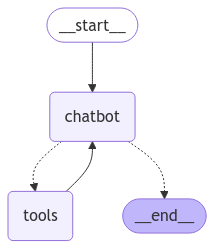

In [57]:
agent.display_graph()

In [53]:

from werkzeug.serving import run_simple

In [49]:
app = Flask(__name__)
@app.route("/")
def home():    
    return render_template("index.html")
@app.route("/get")
def get_bot_response():    
    userText = request.args.get('msg')  
    response = agent.chatbot(userText)  
    #return str(bot.get_response(userText)) 
    return response

if __name__ == "__main__":
   run_simple('localhost', 9000, app)


 * Running on http://localhost:9000
Press CTRL+C to quit
127.0.0.1 - - [07/Feb/2025 00:13:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Feb/2025 00:14:03] "GET /get?msg=how%20are%20you? HTTP/1.1" 200 -
